In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers
import splitfolders
import os

# Weather classification using Transfer learning

# A

In [2]:
splitfolders.ratio("dataset", output="weather", seed=42, ratio=(0.8, 0.1, 0.1),group_prefix=None)

Copying files: 6862 files [01:47, 64.13 files/s] 


# B

In [3]:
# Model Initialization
conv_base = VGG19(weights='imagenet',
                  include_top=False, 
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# C

In [5]:
#def

In [6]:
train_dir = "./weather/train/"
test_dir = "./weather/test/"
valid_dir = "./weather/val/"

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    features_count = len(next(os.walk(directory))[1])
    labels = np.zeros(shape=(sample_count, features_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size= (150, 150), 
                                            batch_size=batch_size, class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features (valid_dir, 500)
test_features, test_labels = extract_features(test_dir, 500)

Found 5484 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

In [9]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.00002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model.fit(train_features, train_labels,
                    epochs = 30, batch_size=batch_size,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 32ms/step - loss: 2.2737 - accuracy: 0.2200 - val_loss: 1.9128 - val_accuracy: 0.3940
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 1.8409 - accuracy: 0.3805 - val_loss: 1.6569 - val_accuracy: 0.4920
Epoch 3/30
100/100 [==============================] - 3s 27ms/step - loss: 1.6137 - accuracy: 0.4490 - val_loss: 1.4831 - val_accuracy: 0.5560
Epoch 4/30
100/100 [==============================] - 2s 23ms/step - loss: 1.4515 - accuracy: 0.5170 - val_loss: 1.3641 - val_accuracy: 0.5840
Epoch 5/30
100/100 [==============================] - 3s 27ms/step - loss: 1.3301 - accuracy: 0.5530 - val_loss: 1.2748 - val_accuracy: 0.6180
Epoch 6/30
100/100 [==============================] - 2s 23ms/step - loss: 1.2428 - accuracy: 0.5870 - val_loss: 1.2082 - val_accuracy: 0.6380
Epoch 7/30
100/100 [==============================] - 3s 27ms/step - loss: 1.1678 - accuracy: 0.6130 - val_loss: 1.1532 - val_accuracy: 0.6480

In [11]:
model.evaluate(test_features, test_labels)

16/16 [==============================] - 0s 5ms/step - loss: 0.7369 - accuracy: 0.7540


[0.736912190914154, 0.7540000081062317]

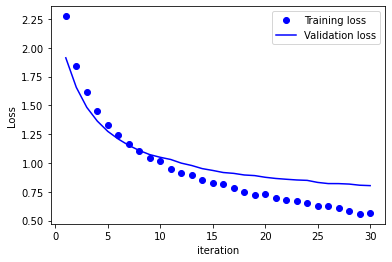

In [12]:
history_dic = history.history
epochs = 30
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'bo', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

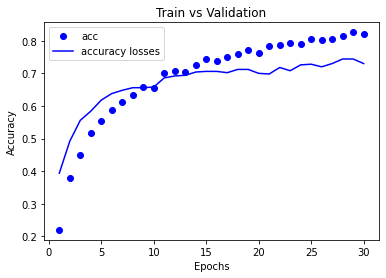

In [13]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'bo', label = "acc")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "accuracy losses")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# G

In [14]:
datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range= 0.2,
                             height_shift_range=20,
                             rotation_range= 40,
                             horizontal_flip=True,
                             zoom_range=0.2,
                             fill_mode='nearest')

In [15]:
batch_size = 20

def extract_features_augmentation(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    features_count = len(next(os.walk(directory))[1])
    labels = np.zeros(shape=(sample_count, features_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size= (150, 150), 
                                            batch_size=batch_size, class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [16]:
train_features, train_labels = extract_features_augmentation(train_dir, 2000)
validation_features, validation_labels = extract_features_augmentation (valid_dir, 500)
test_features, test_labels = extract_features_augmentation(test_dir, 500)

Found 5484 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


In [17]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

In [18]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.00002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 11)                2827      
                                                                 
Total params: 2,101,259
Trainable params: 2,100,747
Non-trainable params: 512
_________________________________________________________________


In [20]:
history_augmentation = model.fit(train_features, train_labels,
                    epochs = 30, batch_size=batch_size,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30


100/100 [==============================] - 5s 29ms/step - loss: 2.5843 - accuracy: 0.2220 - val_loss: 2.0155 - val_accuracy: 0.2680
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 1.9042 - accuracy: 0.3650 - val_loss: 1.6524 - val_accuracy: 0.4240
Epoch 3/30
100/100 [==============================] - 2s 24ms/step - loss: 1.6267 - accuracy: 0.4470 - val_loss: 1.4500 - val_accuracy: 0.5040
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 1.4354 - accuracy: 0.5110 - val_loss: 1.3358 - val_accuracy: 0.5420
Epoch 5/30
100/100 [==============================] - 3s 26ms/step - loss: 1.3117 - accuracy: 0.5475 - val_loss: 1.2367 - val_accuracy: 0.5800
Epoch 6/30
100/100 [==============================] - 2s 24ms/step - loss: 1.2023 - accuracy: 0.5935 - val_loss: 1.1842 - val_accuracy: 0.6000
Epoch 7/30
100/100 [==============================] - 3s 25ms/step - loss: 1.1374 - accuracy: 0.6155 - val_loss: 1.1677 - val_accuracy: 0.6180
Epoch 8/30

In [21]:
model.evaluate(test_features, test_labels)

16/16 [==============================] - 0s 4ms/step - loss: 0.9745 - accuracy: 0.6820


[0.9745320081710815, 0.6819999814033508]

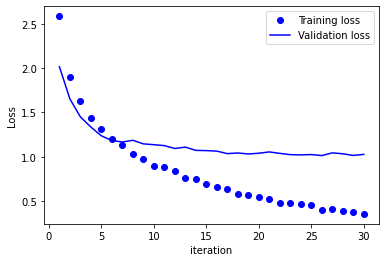

In [22]:
history_dic = history_augmentation.history
epochs = 30
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'bo', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

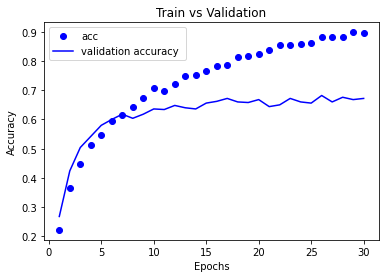

In [23]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'bo', label = "acc")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "validation accuracy ")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2 Weather classification using fine-tuning

In [24]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [25]:
set_trainable =  False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
batch_size = 20
train_datagen = ImageDataGenerator (rescale=1./255)
test_datagen = ImageDataGenerator (rescale=1./255)
validation_datagen = ImageDataGenerator (rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "./weather/train/",
    target_size= (150, 150),
    color_mode='rgb',
    batch_size=batch_size, class_mode='categorical')

test_generator =test_datagen.flow_from_directory(
    "./weather/test/",
    target_size= (150, 150),
    color_mode='rgb',
    batch_size=batch_size, class_mode='categorical')

validation_generator =validation_datagen.flow_from_directory(
     "./weather/val/",
    target_size= (150, 150),
    color_mode='rgb',
    batch_size=batch_size, class_mode='categorical')


Found 5484 images belonging to 11 classes.
Found 696 images belonging to 11 classes.
Found 682 images belonging to 11 classes.


In [27]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.00002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 11)                2827      
                                                      

In [29]:
history = model.fit(train_generator, epochs = 30, batch_size=20,validation_data =validation_generator)

Epoch 1/30
275/275 [==============================] - 1084s 4s/step - loss: 1.4817 - accuracy: 0.5343 - val_loss: 0.8299 - val_accuracy: 0.7346
Epoch 2/30
275/275 [==============================] - 1055s 4s/step - loss: 0.7606 - accuracy: 0.7502 - val_loss: 0.7538 - val_accuracy: 0.7390
Epoch 3/30
275/275 [==============================] - 1024s 4s/step - loss: 0.5425 - accuracy: 0.8178 - val_loss: 0.7584 - val_accuracy: 0.7610
Epoch 4/30
275/275 [==============================] - 1073s 4s/step - loss: 0.4001 - accuracy: 0.8702 - val_loss: 0.5391 - val_accuracy: 0.8299
Epoch 5/30
275/275 [==============================] - 1065s 4s/step - loss: 0.2987 - accuracy: 0.9044 - val_loss: 0.5281 - val_accuracy: 0.8167
Epoch 6/30
275/275 [==============================] - 987s 4s/step - loss: 0.2144 - accuracy: 0.9333 - val_loss: 0.4955 - val_accuracy: 0.8475
Epoch 7/30
275/275 [==============================] - 917s 3s/step - loss: 0.1610 - accuracy: 0.9526 - val_loss: 0.6257 - val_accuracy: 0

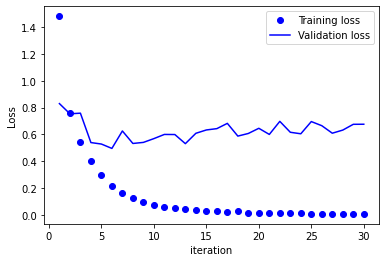

In [30]:
history_dic = history.history
epochs = 30
plt.plot(np.arange(1, epochs + 1), history_dic['loss'], 'bo', label = "Training loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_loss'], 'b', label = "Validation loss")
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

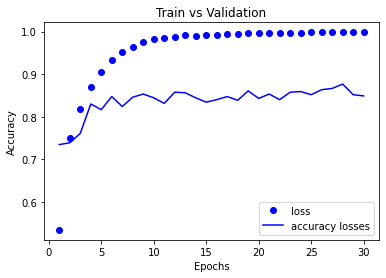

In [31]:
plt.plot(np.arange(1, epochs + 1), history_dic['accuracy'], 'bo', label = "loss")
plt.plot(np.arange(1, epochs + 1), history_dic['val_accuracy'], 'b', label = "accuracy losses")
plt.title("Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()